In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch

import glob, os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from inxss import SpectrumDataset, SpecNeuralRepr, PsiMask, linspace_2D_equidistant
from inxss.specnet import FullSpectrumNetwork
from inxss.dataset import FullSpectrumDataset
from torch.utils.data import DataLoader

/global/homes/z/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_folder = '/pscratch/sd/z/zhantao/inxs_steering/smoothed_SpinW_data/sigma_0.75'

data_file = sorted(glob.glob(os.path.join(data_folder, '*.pt')))

train_data_file, val_test_data_file = train_test_split(data_file, test_size=1/6, random_state=42)
val_data_file,   test_data_file     = train_test_split(val_test_data_file, test_size=0.5, random_state=42)

train_dataset = FullSpectrumDataset(
    data_file = train_data_file,
    grid_file = '/pscratch/sd/z/zhantao/inxs_steering/smoothed_SpinW_data/sigma_0.75/grid_metadata',
    num_coords_per_sample = 10000
)
val_dataset = FullSpectrumDataset(
    data_file = val_data_file,
    grid_file = '/pscratch/sd/z/zhantao/inxs_steering/smoothed_SpinW_data/sigma_0.75/grid_metadata',
    num_coords_per_sample = 10000
)
test_dataset = FullSpectrumDataset(
    data_file = test_data_file,
    grid_file = '/pscratch/sd/z/zhantao/inxs_steering/smoothed_SpinW_data/sigma_0.75/grid_metadata',
    num_coords_per_sample = 10000
)

In [4]:
model = FullSpectrumNetwork.load_from_checkpoint(
    '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896863/checkpoints/last.ckpt'
    )

# model = SpecNeuralRepr.load_from_checkpoint(
#     '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896843/checkpoints/epoch=1165-step=55968.ckpt'
# )

In [5]:
from inxss import linspace_2D_equidistant, plot_points, get_Sqw_func

In [22]:
kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
wpts = torch.from_numpy(train_dataset.w_grid.copy())

In [9]:
x = torch.zeros(wpts.shape[0], kpts.shape[0], 6)

In [11]:
# fig, ax = plt.subplots(1,1)
# ax.scatter(spec_dataset.data_dict['params'][train_idx,0], spec_dataset.data_dict['params'][train_idx,1], label='train')
# ax.scatter(spec_dataset.data_dict['params'][val_idx,0], spec_dataset.data_dict['params'][val_idx,1], label='val')
# ax.scatter(spec_dataset.data_dict['params'][test_idx,0], spec_dataset.data_dict['params'][test_idx,1], label='test')
# ax.set_xlabel('$J$', fontsize=16)
# ax.set_ylabel('$J_{p}$', fontsize=16)
# ax.legend()
# fig.savefig('sample_split.svg', bbox_inches='tight')

In [23]:
kpts = torch.cat([kpts, torch.ones_like(kpts[:,0:1])], dim=-1)

In [20]:
params

array([26.83529766,  4.50581591])

In [24]:
idx_plot = 3
params = test_dataset[idx_plot][0][0, -2:]

x[...,:4] = torch.cat([
    kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
    wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
   ], dim=2)
x[...,4:] = params

S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()

In [47]:
from scipy.interpolate import RegularGridInterpolator
S_true_func = RegularGridInterpolator(
    (np.linspace(0, 0.5, 101), np.linspace(0, 0.5, 101), wpts.numpy()), 
    spec_dataset.data_dict['S'][test_idx[idx_plot]].reshape(-1, 101, 101).permute(1,2,0).numpy(), fill_value=0, bounds_error=False)
S_true = S_true_func(x.detach().numpy()[...,[0,1,3]])
# plt.imshow(S_true, origin='lower')

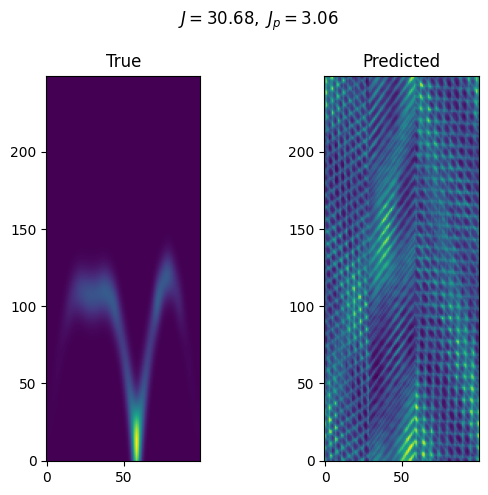

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(6, 5))
ax[0].imshow(S_true, origin='lower')
ax[0].set_title('True')
ax[1].imshow(S_pred, origin='lower')
ax[1].set_title('Predicted')

fig.suptitle(rf'$J={params[0]:.2f}, \ J_{{p}}={params[1]:.2f}$')
fig.tight_layout()
# fig.savefig(f"test_idx_{idx_plot}.svg", bbox_inches='tight')